# Company Bankruptcy Prediction

### Cel biznesowy
Predykcja brankructwa firm na podstawie parametrów ekonomicznych

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from scipy.stats import randint
from sklearn.exceptions import FitFailedWarning
import warnings


In [106]:
db_raw = pd.read_csv('./db/data.csv') 
db_raw.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## EDA

Sprawdzenie wartości null w danych kolumnach

**Wniosek**: brak wratości null

In [ ]:
db_raw.describe()

In [ ]:
db_raw.info()

Sprawdzenie ile firm zbankrutowało, a ile nie

In [ ]:
db_raw['Bankrupt?'].value_counts()

Wyrzucenie ' Net Income Flag' - 0 dla każdego recordu

In [107]:
db = db_raw.drop([' Net Income Flag'], axis=1)

Podzielenie na zbiór treningowy i walidacyjny do sprawdzenia poprawności założeń


In [108]:
target = db['Bankrupt?']
db = db.drop(['Bankrupt?'], axis=1)

In [109]:
x_temp, x_valid, y_temp, y_valid = train_test_split(db, target, test_size=0.3, stratify = target, random_state = 42)
x_train, x_test, y_train, y_test = train_test_split(x_temp, y_temp, test_size=0.3, stratify = y_temp, random_state = 42)

Sprawdzenie zależności miedzy bankrupctwem a pozostałymi parametrami celem wyszczególenia tych najbardziej istotnych

Za pomocą boxplot

In [ ]:
for i in range(10, 20):
    fig, ax = plt.subplots(figsize=(25,8))
    sns.boxplot(x=y_train, y=x_train[x_train.columns[i]], ax=ax)
    ax.set_title(f'Boxplot of {x_train.columns[i]}')
    print(i)
    plt.show()

oraz za pomocą heatmapy korelacji

In [ ]:
spearman_corr = db.corr('spearman')
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

plt.figure(figsize=(25, 20))
sns.heatmap(spearman_corr, mask=mask, square=True, linewidths=0.5, cmap='coolwarm')
plt.show()

Wybór kolumn z najbardziej widocznymi zależnościami do dalszych badań korelacji

In [ ]:
print(spearman_corr['Bankrupt?'].sort_values(ascending=False).head(15))
print(spearman_corr['Bankrupt?'].sort_values(ascending=False).tail(30))

Wizualizacja kilku ciekawych parametrów za pomocą boxplotów

In [ ]:
plt.subplots(ncols=5, figsize=(25,8))

sns.boxplot(x='Bankrupt?', y=" Persistent EPS in the Last Four Seasons", data=db, ax=plt.subplot(1, 5, 1))
sns.boxplot(x='Bankrupt?', y=" Net Income to Total Assets", data=db, ax=plt.subplot(1, 5, 2))
sns.boxplot(x='Bankrupt?', y=" ROA(B) before interest and depreciation after tax", data=db, ax=plt.subplot(1, 5, 3))
sns.boxplot(x='Bankrupt?', y=" Net Value Per Share (B)", data=db, ax=plt.subplot(1, 5, 4))
sns.boxplot(x='Bankrupt?', y=" Equity to Long-term Liability", data=db, ax=plt.subplot(1, 5, 5))

## Preprocessing

### Obsługa outlierów

In [111]:
for column in x_train.columns:
    upper_lim = x_train[column].quantile(.99)
    lower_lim = x_train[column].quantile(.01)

    x_train.loc[x_train[column] > upper_lim, column] = upper_lim
    x_train.loc[x_train[column] < lower_lim, column] = lower_lim

    x_test.loc[x_test[column] > upper_lim, column] = upper_lim
    x_test.loc[x_test[column] < lower_lim, column] = lower_lim
    
    x_valid.loc[x_valid[column] > upper_lim, column] = upper_lim
    x_valid.loc[x_valid[column] < lower_lim, column] = lower_lim

### Normalizacja

In [112]:
scaler = MinMaxScaler()
scaler.fit_transform(x_train)

x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
x_valid = pd.DataFrame(scaler.transform(x_valid), columns=x_valid.columns)

### Wybór najważniejszych cech

In [113]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)
perm_importance = permutation_importance(rf_model, x_train, y_train, n_repeats=100, random_state=42)

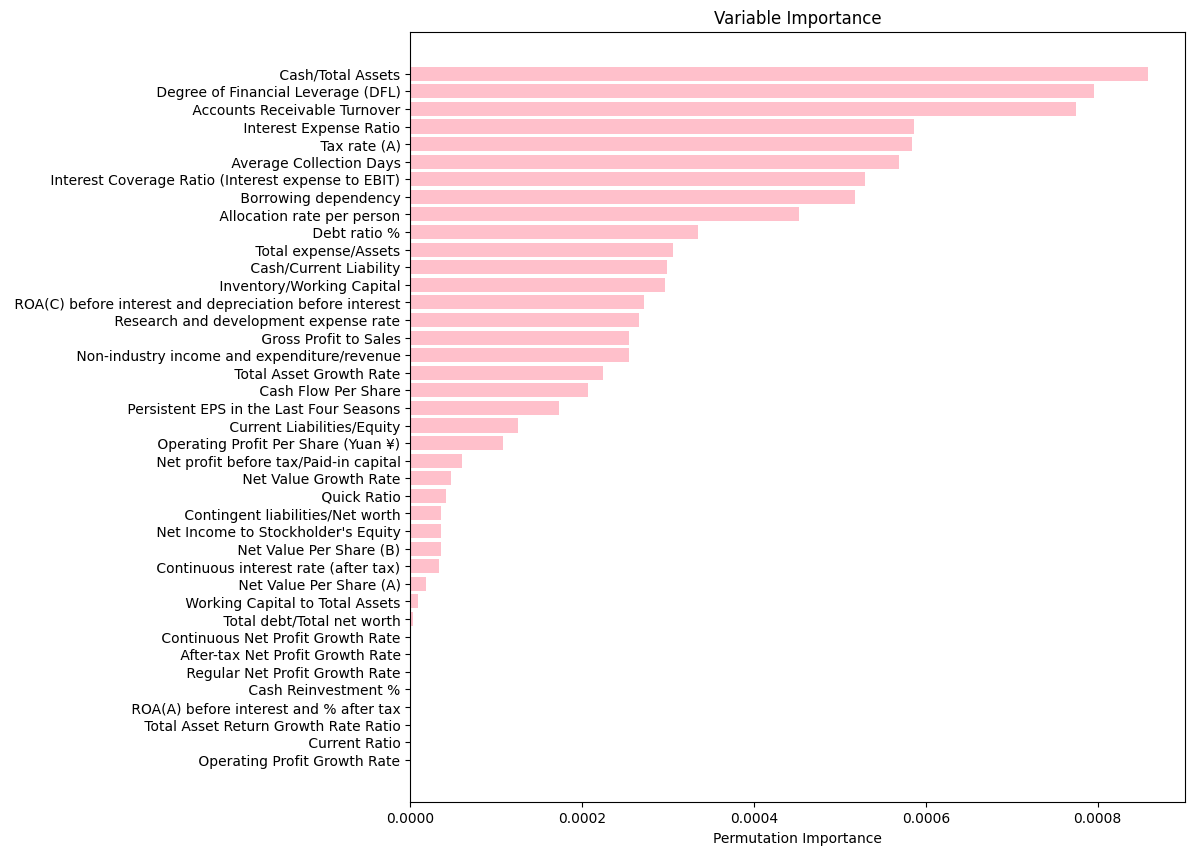

In [114]:
sorted_idx = perm_importance.importances_mean.argsort()
top_vars = 40

x_test = x_test[x_train.columns[sorted_idx][-top_vars:]]
x_valid = x_valid[x_train.columns[sorted_idx][-top_vars:]]
x_train = x_train[x_train.columns[sorted_idx][-top_vars:]]

plt.figure(figsize=(10, 10))
plt.barh(range(top_vars), perm_importance.importances_mean[sorted_idx][-top_vars:], color='pink')
plt.yticks(range(top_vars), x_train.columns)
plt.xlabel('Permutation Importance')
plt.title('Variable Importance')
plt.show()

## Modeling

In [115]:
def show_metrics(y_real, y_pred):    
    precision = precision_score(y_real, y_pred)
    accuracy = accuracy_score(y_real, y_pred)
    recall = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)

    roc_auc = roc_auc_score(y_real, y_pred)
    gini = 2 * roc_auc - 1

    print('-'*30)
    print(f'accuracy: {accuracy:.5f}')
    print(f'precision: {precision:.5f}')
    print(f'recall: {recall:.5f}')
    print(f'f1: {f1:.5f}')
    print('-'*30)
    print(f'ROC_AUC: {roc_auc:.5f}')
    print(f'GINI: {gini:.5f}')
    print('-'*30)

Ukrycie warningów związanych z niepoprawnym dobraniem parametrów do strojenia hiperparametrów

In [116]:
warnings.filterwarnings('ignore', category=FitFailedWarning)
warnings.filterwarnings('ignore', category=UserWarning)


### LogisticRegression

In [117]:
param_distributions = {
        'solver': ['newton-cg', 'lbfgs', 'sag', 'liblinear', 'saga'],
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'class_weight': ['balanced', None],
        'max_iter': list(range(100, 800, 100)),
    }


random_search = RandomizedSearchCV(
    estimator=LogisticRegression(),
    param_distributions=param_distributions,
    scoring='roc_auc',
    n_iter=10,
    cv=5,
    random_state=420,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

best_estimator = random_search.best_estimator_

In [118]:
y_pred_log_reg = best_estimator.predict(x_test)
show_metrics(y_test, y_pred_log_reg)

------------------------------
accuracy: 0.87779
precision: 0.18537
recall: 0.82609
f1: 0.30279
------------------------------
ROC_AUC: 0.85280
GINI: 0.70560
------------------------------


### Random Forest

In [119]:
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'max_features' : ['sqrt', 'log2'],
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=420),
    param_distributions=param_distributions,
    scoring='roc_auc',
    n_iter=10,
    cv=5,
    random_state=420,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

best_estimator = random_search.best_estimator_

In [120]:
y_pred_rand_for = best_estimator.predict(x_test)
show_metrics(y_test, y_pred_rand_for)

------------------------------
accuracy: 0.95880
precision: 0.40299
recall: 0.58696
f1: 0.47788
------------------------------
ROC_AUC: 0.77905
GINI: 0.55810
------------------------------


### CatBoost

In [132]:
param_distributions = {
    'eval_metric': ['F1', 'AUC', 'Accuracy', 'Precision', 'Recall'],
    'iterations': [100, 500, 1000],
    'learning_rate' : [0.1, 0.01, 0.001],
    'auto_class_weights' : ['Balanced','SqrtBalanced'],
}

random_search = RandomizedSearchCV(
    CatBoostClassifier(random_state=42, verbose=0), 
    param_distributions=param_distributions,
    scoring='roc_auc',
    n_iter=10,
    cv=5,
    random_state=420,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

best_estimator = random_search.best_estimator_

In [133]:
y_pred_cat = best_estimator.predict(x_test)
show_metrics(y_test, y_pred_cat)

------------------------------
accuracy: 0.96020
precision: 0.41270
recall: 0.56522
f1: 0.47706
------------------------------
ROC_AUC: 0.76926
GINI: 0.53852
------------------------------


### SVC

In [123]:

param_distributions = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced', None],
    'max_iter': list(range(100, 800, 100)),
}

random_search = RandomizedSearchCV(
    estimator=SVC(probability=True),
    param_distributions=param_distributions,
    scoring='roc_auc',
    n_iter=10,
    cv=5,
    random_state=420,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

best_estimator = random_search.best_estimator_

In [124]:
y_pred_svc = best_estimator.predict(x_test)
show_metrics(y_test, y_pred_svc)

------------------------------
accuracy: 0.89735
precision: 0.21143
recall: 0.80435
f1: 0.33484
------------------------------
ROC_AUC: 0.85239
GINI: 0.70478
------------------------------


## Results

### ROC Curve

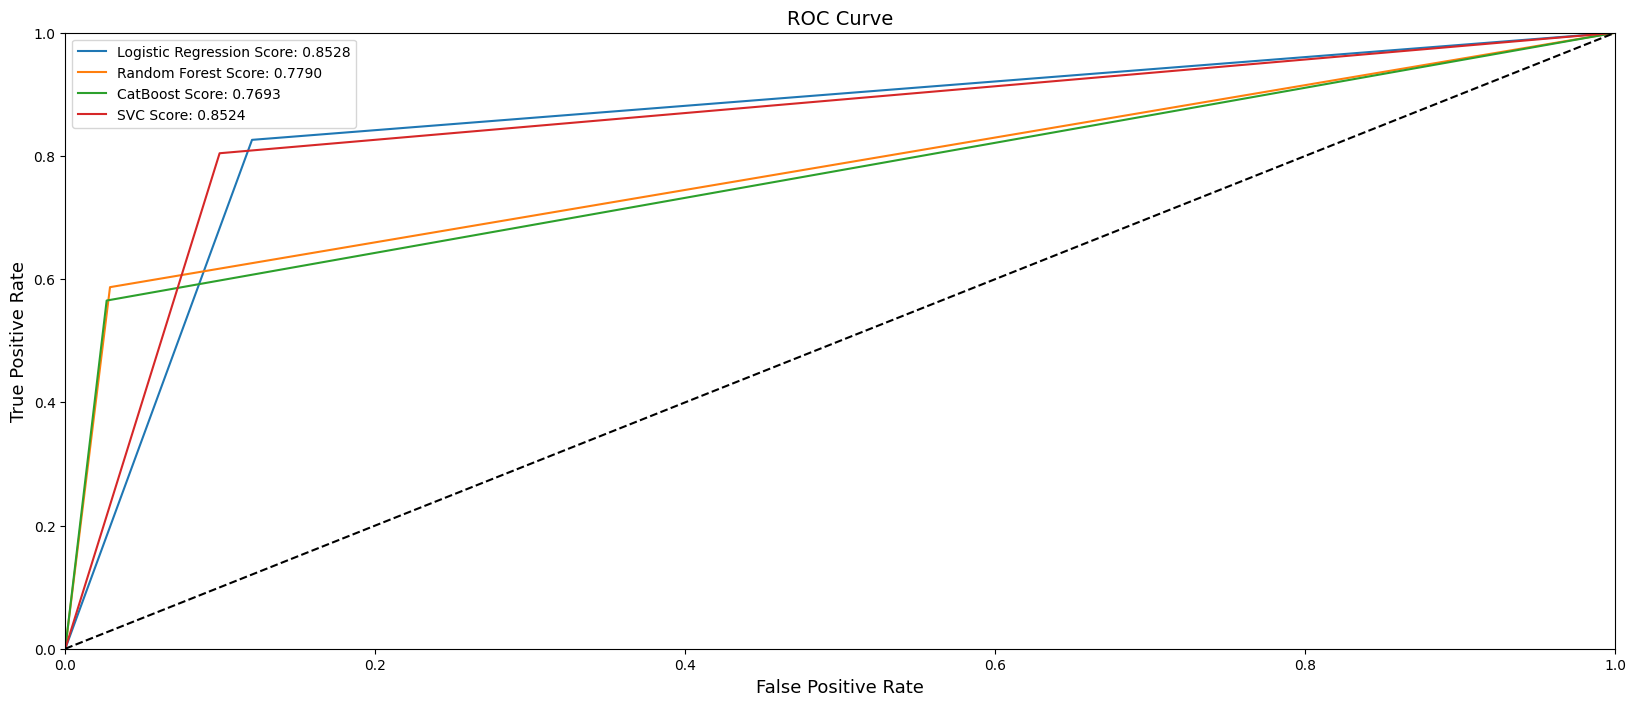

In [125]:
log_fpr, log_tpr, _ = roc_curve(y_test, y_pred_log_reg)
for_fpr, for_tpr, _ = roc_curve(y_test, y_pred_rand_for)
cat_fpr, cat_tpr, _ = roc_curve(y_test, y_pred_cat)
svc_fpr, svc_tpr, _ = roc_curve(y_test, y_pred_svc)


plt.figure(figsize=(20,8))
plt.title('ROC Curve', fontsize=14)
plt.plot(log_fpr, log_tpr, label=f'Logistic Regression Score: {roc_auc_score(y_test, y_pred_log_reg):.4f}')
plt.plot(for_fpr, for_tpr, label=f'Random Forest Score: {roc_auc_score(y_test, y_pred_rand_for):.4f}')
plt.plot(cat_fpr, cat_tpr, label=f'CatBoost Score: {roc_auc_score(y_test, y_pred_cat):.4f}')
plt.plot(svc_fpr, svc_tpr, label=f'SVC Score: {roc_auc_score(y_test, y_pred_svc):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.legend()
    
plt.show()

### Confusion matrix

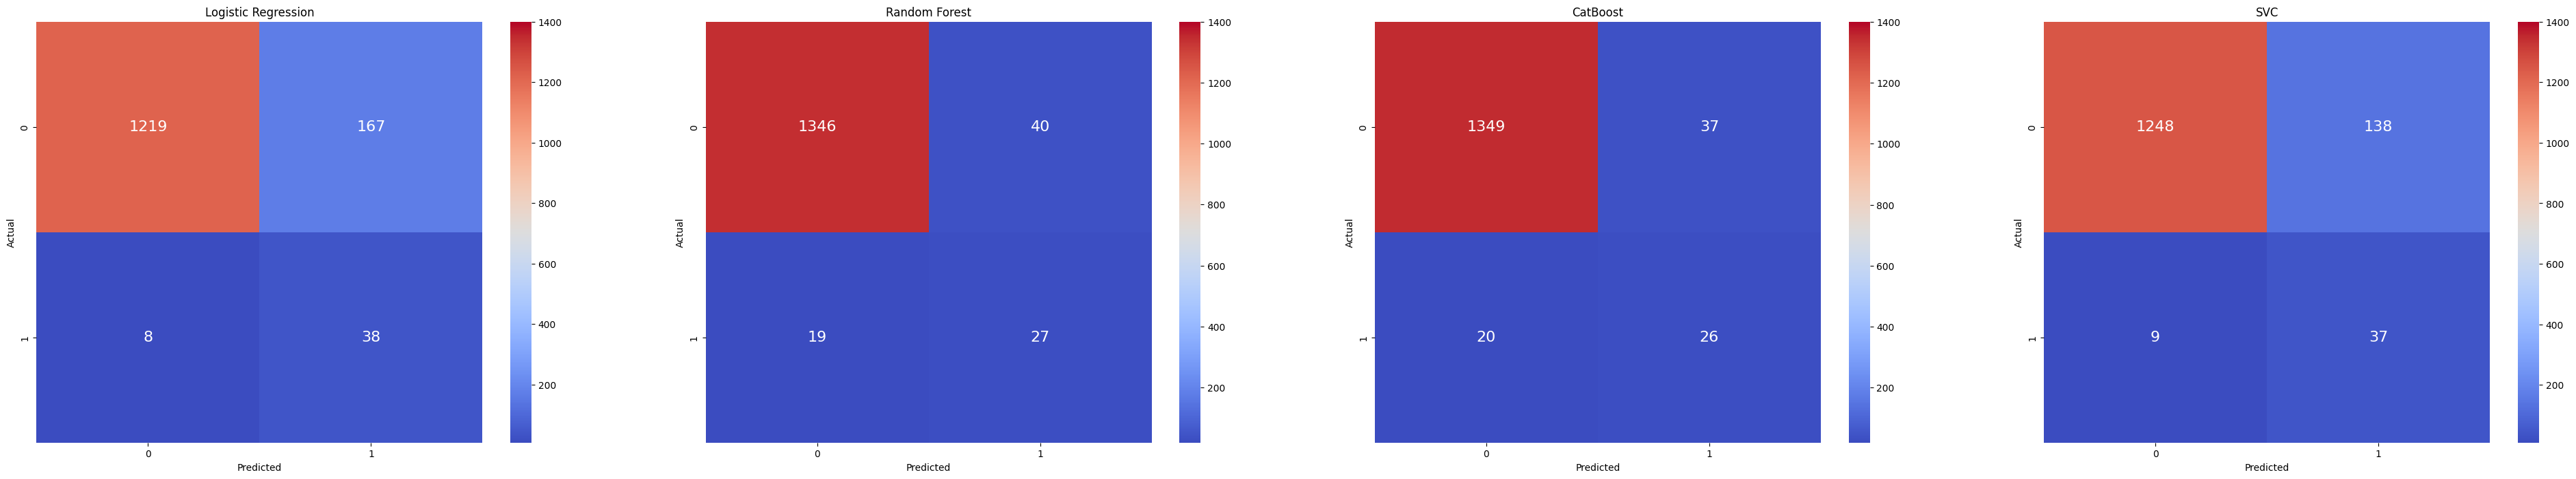

In [151]:
mx_log_reg = confusion_matrix(y_test, y_pred_log_reg)
mx_rand_for = confusion_matrix(y_test, y_pred_rand_for)
mx_cat = confusion_matrix(y_test, y_pred_cat)
mx_svc = confusion_matrix(y_test, y_pred_svc)

hm_log_reg = pd.DataFrame(mx_log_reg)
hm_rand_for = pd.DataFrame(mx_rand_for)
hm_cat = pd.DataFrame(mx_cat)
hm_svc = pd.DataFrame(mx_svc)

f, ax = plt.subplots(1, 4, figsize=(20,8))
f.subplots_adjust(right= 2)

sns.heatmap(hm_log_reg, cmap='coolwarm', annot=True, annot_kws={"size": 16}, fmt='g', ax = ax[0], vmax=1400)
ax[0].set(xlabel='Predicted', ylabel='Actual', title='Logistic Regression')
sns.heatmap(hm_rand_for, cmap='coolwarm', annot=True, annot_kws={"size": 16}, fmt='g', ax = ax[1], vmax=1400)
ax[1].set(xlabel='Predicted', ylabel='Actual', title='Random Forest')
sns.heatmap(hm_cat, cmap='coolwarm', annot=True, annot_kws={"size": 16}, fmt='g', ax = ax[2], vmax=1400)
ax[2].set(xlabel='Predicted', ylabel='Actual', title='CatBoost')
sns.heatmap(hm_svc, cmap='coolwarm', annot=True, annot_kws={"size": 16}, fmt='g', ax = ax[3], vmax=1400)
ax[3].set(xlabel='Predicted', ylabel='Actual', title='SVC')

plt.show()